# Motion Model

The robot is moving according to the following "constant velocity model" model:

$\\x_{i+1}=x_{i}+\frac{V_{i}}{\omega{i}}sin(\theta_{i}+\omega_{i}\Delta t)\\
\\
y_{i+1}=y_{i}-\frac{V_{i}}{\omega{i}}cos(\theta_{i}+\omega_{i}\Delta t) \\
\\
\theta_{i+1}=\theta_{i}+\omega_{i}\Delta t
$

The previous model is not accurate due to the error in velocity components, A more realistic model can be written as follows:
$\\ x_{i+1}=x_{i}+\frac{V_{i}+\Delta V}{\omega{i}+\Delta \omega}sin(\theta_{i}+(\omega_{i}+\Delta \omega)\Delta t)\\
\\
y_{i+1}=y_{i}-\frac{V_{i}+\Delta V}{\omega{i}+\Delta \omega}cos(\theta_{i}+(\omega_{i}+\Delta \omega)\Delta t)) \\
\\
\theta_{i+1}=\theta_{i}+(\omega_{i}+\Delta \omega)\Delta t
$

These noise components "for simplicity and it is not a realistic valid approximation" will be considered to be white noises with probability distribution defined as follows: 
$\\ \Delta V \sim N(0;\sigma_{v}^{2}), \\
\Delta \omega \sim N(0;\sigma_{\omega}^{2}).$

In [50]:
# simulating robot motion
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [51]:
sigma_v=1.5
sigma_w=0.01
V=10
omega=0.1
T=50
dt=1

def propgate_state(X,v,w,step):
    x=X[0]
    y=X[1]
    theta=X[2]
    X[0]=x+v*np.sin(theta+w*step)/w
    X[1]=y-v*np.cos(theta+w*step)/w
    X[2]=theta+w*dt
    return X


state_vector=np.zeros([3,T])
real_state_vector=np.zeros_like(state_vector)

state_vector[:,1]=np.array([0,0,0]).transpose()
real_state_vector[:,1]=np.array([0,0,0])

for i in range(T-1):
    real_vel=V+sigma_v*np.random.randn()
    real_omega=omega+sigma_w*np.random.randn()
    
    real_state_vector[:,i+1]=propgate_state(real_state_vector[:,i],real_vel,real_omega,dt)
    state_vector[:,i+1]=propgate_state(state_vector[:,i],V,omega,dt)
    



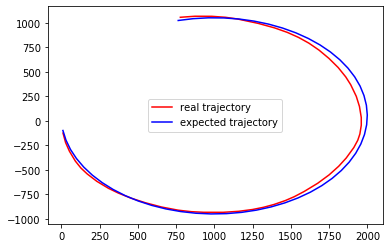

In [52]:
plt.plot(real_state_vector[0,:],real_state_vector[1,:],'r',label='real trajectory')
plt.plot(state_vector[0,:],state_vector[1,:],'b',label='expected trajectory')
plt.legend()

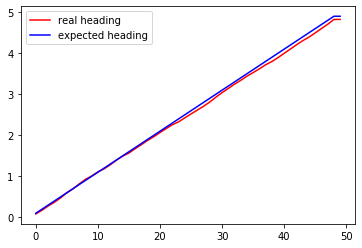

In [53]:
plt.plot(real_state_vector[2,:],'r',label='real heading')
plt.plot(state_vector[2,:],'b',label='expected heading')
plt.legend()

## Motion model
$\\ x_{i+1}=x_{i}+\frac{V_{i}+\Delta V}{\omega{i}+\Delta \omega}sin(\theta_{i}+(\omega_{i}+\Delta \omega)\Delta t)\\
\\
y_{i+1}=y_{i}-\frac{V_{i}+\Delta V}{\omega{i}+\Delta \omega}cos(\theta_{i}+(\omega_{i}+\Delta \omega)\Delta t)) \\
\\
\theta_{i+1}=\theta_{i}+(\omega_{i}+\Delta \omega)\Delta t \\
$

This motion model can be rewritten as follows
---
$
\textbf{X}_{i+1}=f(\textbf{X}_{i},u_{i},\epsilon_{i});
\\
u_{i}=[V_{i},\omega_{i}]^{T}\\
\epsilon_{i}=\epsilon=[\Delta V,\Delta \omega]^{T}, \\
\epsilon \sim N(\textbf{0},q)$  \\
---

Jacobians
$:\\
F=(\frac{\partial f}{\partial \textbf{X}})_{(\textbf{X}=\hat{X}_{i},\epsilon={\textbf{0}})}\\
G=(\frac{\partial f}{\partial  \epsilon})_{(\textbf{X}=\hat{X}_{i},\epsilon={\textbf{0}})}$



# EKF prediciton
$\textbf{X}_{i+1|i}=f(\hat{\textbf{X}}_{i},u_{i},\textbf{0}), \\
\\
\\
\textbf{P}_{i+1|i}=F\textbf{P}_{i}F^{T}+GqG^{T}.$
---

# Measurement model
$r_{i}=\sqrt{(x_{i}-m_{ix})^2 +(y_{i}-m_{iy})^2} + v_{r}, \\
\Phi_{i}=\tan^{-1}{\frac{m_{iy}-y_{i}}{m_{ix}-x_{i}}}-\theta_{i}+v_{\phi}; \\
v_{r}\sim N(0;\sigma_{v_{r}}^{2}),\\
v_{\phi}\sim N(0;\sigma_{v_{\phi}})^{2}
$

The previous can be rewritten as:

$ z_{i}=h(\textbf{X}_{i})+v;\\
v=[v_{r},v_{\phi}]^{T},\\
v \sim N(\textbf{0},R)$
---

Jacobians 
$:\\
H=(\frac{\partial h}{\partial \textbf{X}})_{(\textbf{X}=\hat{X}_{i},v={\textbf{0}})}$


# EKF update
$K=\frac{\textbf{P}_{i+1|i}H^{T}}{H\textbf{P}_{i+1|i}H^{T}+R},\\
\hat{\textbf{X}}_{i+1}=\textbf{X}_{i+1|i}+K(z_{i+1}-h(\textbf{X}_{i+1|i}), \\
\textbf{P}_{i+1}=(\textbf{I}-KH)\textbf{P}_{i+1|i}$

In [54]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [55]:
def propgate_state_and_measurements(X,v,w,dt,mx,my,vr,vphi):
    z=np.array([0,0]).transpose()
    
    x=X[0]
    y=X[1]
    theta=X[2]
    
    X[0]=x+v*np.sin(theta+w*dt)/w
    X[1]=y-v*np.cos(theta+w*dt)/w
    X[2]=theta+w*dt
    
    z[0]=np.sqrt((X[0]-mx)**2+(X[1]-my)**2)+vr
    z[1]=np.arctan((my-X[1])/(mx-X[0]))-X[2]+vphi
    
    return X,z

In [56]:
def ekf_predict(X_hat,P,q,v,w,dt): #v & w are the nominal values of u vector (i.e. V and omega)

    F=np.array([[1,0,(v/w)*np.cos(X_hat[2]+w*dt)],
               [0,1,(v/w)*np.sin(X_hat[2]+w*dt)],
               [0,0,1]])
    G=np.array([[(1/w)*np.sin(X_hat[2]+w*dt),(v/w)*np.cos(X_hat[2]+w*dt)*dt-(v/w**2)*np.sin(X_hat[2]+w*dt)],
               [-(1/w)*np.cos(X_hat[2]+w*dt),(v/w)*np.sin(X_hat[2]+w*dt)*dt+(v/w**2)*np.cos(X_hat[2]+w*dt)],
               [0,dt]])
    X_hat=F@X_hat
    P=F@P@np.transpose(F)+G@q@np.transpose(G)
    
    return X_hat, P

def ekf_update(X_hat,P,z,R,mx,my):
    
    H=np.array([[(X_hat[0]-mx)/np.sqrt((X_hat[0]-mx)**2+(X_hat[1]-my)**2),(X_hat[1]-my)/np.sqrt((X_hat[0]-mx)**2+(X_hat[1]-my)**2),0],
               [(X_hat[0]-mx)/(-X_hat[0]+mx)**2+(-X_hat[1]+my)**2,(X_hat[1]-my)/(-X_hat[0]+mx)**2+(-X_hat[1]+my)**2,-1]])
    
    S=H@P@np.transpose(H)+R
    K=P@np.transpose(H)@np.linalg.inv(S)
    X_hat=X_hat+K@(z-H@X_hat)
    P=P-K@H@P
    
    return X_hat, P


In [63]:
sigma_v=1.5
sigma_w=0.01
sigma_vr=0.1
sigma_vphi=0.1
mx=0
my=0
V=10
omega=w=0.1
T=50
dt=1
q=np.diag([sigma_v**2,sigma_w**2])
R=np.diag([sigma_vr**2,sigma_vphi**2])
X=X_hat=np.zeros([3,T])
z=np.zeros([2,T])
z[:,0]=np.array([0,0]).transpose()
X_hat[:,0]=X[:,0]=np.array([0,0,0]).transpose()
P=np.zeros([3,3,T])
P[:,:,0]=np.identity(3)

In [64]:
#for loop to propagate state and measurements

for i in range(T-1):
    rv=V+sigma_v*np.random.randn()
    rw=w+sigma_w*np.random.randn()
    rvr=sigma_vr*np.random.randn()
    rvp=sigma_vphi*np.random.randn()
    
    X[:,i+1],z[:,i+1]=propgate_state_and_measurements(X[:,i],rv,rw,dt,mx,my,rvr,rvp)
    
    
#for loop to predict and update estimates

for i in range(T-1):
    X_hat[:,i+1],P[:,:,i+1]=ekf_predict(X_hat[:,i],P[:,:,i],q,V,w,dt)
    X_hat[:,i+1],P[:,:,i+1]=ekf_update(X_hat[:,i+1],P[:,:,i+1],z[:,i],R,mx,my)

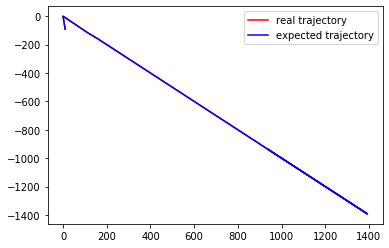

In [65]:
#plots
plt.plot(X[0,:],X[1,:],'r',label='real trajectory')
plt.plot(X_hat[0,:],X_hat[1,:],'b',label='expected trajectory')
plt.legend()

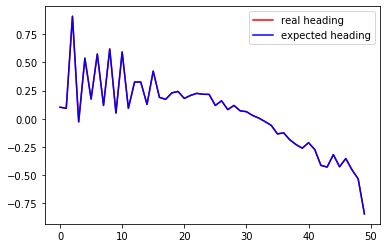

In [60]:
plt.plot(X[2,:],'r',label='real heading')
plt.plot(X_hat[2,:],'b',label='expected heading')
plt.legend()